In [65]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from grnkit.data import Dream4MultifactorialDataset, Dream4TimeseriesDataset
from grnkit.evaluate import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


class simpleA(nn.Module):
    def __init__(self, n_genes):
        super(simpleA, self).__init__()
        self.A = nn.Linear(n_genes, n_genes, bias=False)
        self.A.weight = nn.Parameter(torch.zeros(n_genes, n_genes))
        nn.init.xavier_normal_(self.A.weight)
        
    def forward(self, X0):
        return self.A(X0)

In [8]:
a = torch.ones(10, 5) 
b = torch.arange(10)

In [20]:
a * b.repeat(5, 1).t()

tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6.],
        [7., 7., 7., 7., 7.],
        [8., 8., 8., 8., 8.],
        [9., 9., 9., 9., 9.]])

In [25]:
aaa = nn.Parameter(torch.empty((10, 5)))

In [26]:
aaa

Parameter containing:
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00],
        [3.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00],
        [4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00],
        [5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00],
        [6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00],
        [7.0000e+00, 7.0000e+00, 7.0000e+00, 7.0000e+00, 7.0000e+00],
        [8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [9.0000e+00, 9.0000e+00, 9.0000e+00, 9.0000e+00, 9.0000e+00],
        [9.0000e+00, 9.0000e+00, 9.0000e+00, 2.5244e-29, 2.5244e-29]],
       requires_grad=True)

In [23]:
aaa * b.repeat(5, 1).t()

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00],
        [ 6.0000e+00,  6.0000e+00,  6.0000e+00,  6.0000e+00,  6.0000e+00],
        [ 1.2000e+01,  1.2000e+01,  1.2000e+01,  1.2000e+01,  1.2000e+01],
        [ 2.0000e+01,  2.0000e+01,  2.0000e+01,  2.0000e+01,  2.0000e+01],
        [ 3.0000e+01,  3.0000e+01,  3.0000e+01,  3.0000e+01,  3.0000e+01],
        [ 4.2000e+01,  4.2000e+01,  4.2000e+01,  4.2000e+01,  4.2000e+01],
        [ 5.6000e+01,  5.6000e+01,  5.6000e+01,  5.6000e+01,  5.6000e+01],
        [ 7.2000e+01,  7.2000e+01,  7.2000e+01,  7.2000e+01,  7.2000e+01],
        [ 8.1000e+01,  8.1000e+01,  8.1000e+01,  0.0000e+00, -2.2719e-28]],
       grad_fn=<MulBackward0>)

In [83]:
class geneEmbedding(nn.Module):
    def __init__(self, n_genes, emb_dim):
        super(geneEmbedding, self).__init__()
        self.gene_embedding = nn.Parameter(torch.empty((n_genes, emb_dim)))
        self.A = nn.Parameter(torch.empty((n_genes, n_genes)))
        self.gene_classifier_1 = nn.Linear(emb_dim, n_genes // 2)
        self.gene_classifier_2 = nn.Linear(n_genes // 2, n_genes)
        
        self.reset_parameters()
        self.n_genes = n_genes
        self.emb_dim = emb_dim
        
    def reset_parameters(self) -> None:
        nn.init.xavier_normal_(self.gene_embedding)
        nn.init.xavier_normal_(self.A)
        nn.init.xavier_normal_(self.gene_classifier_1.weight)
        nn.init.xavier_normal_(self.gene_classifier_2.weight)
        
    def forward(self, X):
        X_embedding = self.gene_embedding * X.repeat(self.emb_dim, 1).t()
        h = self.A @ X_embedding
        h = F.relu(self.gene_classifier_1(h))
        return torch.softmax(self.gene_classifier_2(h), dim=1)

In [84]:
dt = Dream4MultifactorialDataset(1)


In [85]:
gE = geneEmbedding(100, 16)


In [90]:
torch.tensor(dt.expression_data[0, :]).repeat(16, 1).shape

torch.Size([16, 100])

In [96]:
aaa = gE(torch.FloatTensor(dt.expression_data[0, :]))

In [94]:
y_target = torch.arange(100)

In [97]:
F.cross_entropy(aaa, y_target)

tensor(4.6052, grad_fn=<NllLossBackward0>)

100%|███████████████████████████████████████| 2000/2000 [01:23<00:00, 24.07it/s]


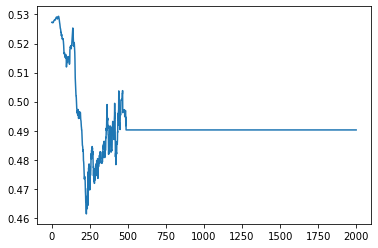

In [105]:
dt = Dream4MultifactorialDataset(1)
n_epoch = 2000
n_genes = dt.number_of_genes

gE = geneEmbedding(n_genes, 4)
opt = torch.optim.Adam(gE.parameters(), lr=1E-5, weight_decay=0.001)

metrics = {'loss':[], 'auroc': [], 'aupr': []}
for epoch in tqdm(range(n_epoch)):
    epoch_loss = []
    for i in range(dt.expression_data.shape[0]):
        X = torch.FloatTensor(dt.expression_data[i, :])
        y_target = torch.arange(n_genes)
        y_pred = gE(X)
        loss = F.cross_entropy(y_pred, y_target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss.append(loss.detach().item())
        
    vim = gE.A.detach().numpy()
    y_pred = np.array([score[1] for score in np.ndenumerate(vim)])
    test_eval = evaluate(dt.gold_standard, np.abs(y_pred), print_auc=False)
    metrics['loss'].append(np.mean(epoch_loss))
    metrics['auroc'].append(test_eval['AUROC'])
    metrics['aupr'].append(test_eval['AUPRC'])
    # print("Epoch " + str(epoch) + ': loss: ' + str(np.round(np.mean(epoch_loss), 4)))
    
plt.plot(np.arange(n_epoch), metrics['auroc'])

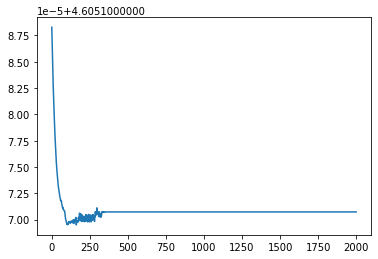

In [106]:
plt.plot(np.arange(n_epoch), metrics['loss'])

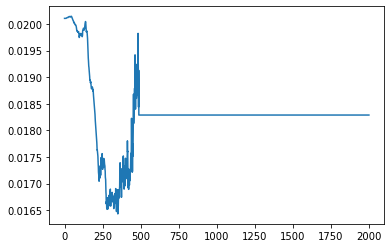

In [107]:
plt.plot(np.arange(n_epoch), metrics['aupr'])

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 191.14it/s]


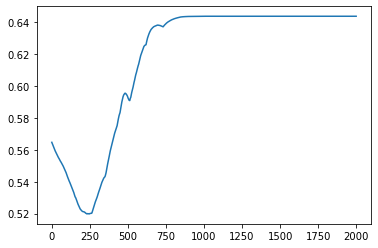

In [2]:
dt = Dream4TimeseriesDataset(100, 1)
n_epoch = 2000
p = 1
n_genes = dt.number_of_genes

A = simpleA(n_genes)
opt = torch.optim.Adam(A.parameters(), lr=1E-4, weight_decay=0.001)

metrics = {'loss':[], 'auroc': [], 'aupr': []}
for epoch in tqdm(range(n_epoch)):
    epoch_loss = []
    for i in range(dt.n_ts):
        ts_dt = dt.expression_data[i]
        X_input = torch.FloatTensor(ts_dt[:(21-p), :])
        X_target = torch.FloatTensor(ts_dt[p:, :])
        X_pred = A(X_input) + X_input
        loss = torch.nn.functional.huber_loss(X_pred, X_target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss.append(loss.detach().item())
        
    vim = A.A.weight.detach().numpy()
    y_pred = np.array([score[1] for score in np.ndenumerate(vim)])
    test_eval = evaluate(dt.gold_standard, np.abs(y_pred), print_auc=False)
    metrics['loss'].append(np.mean(epoch_loss))
    metrics['auroc'].append(test_eval['AUROC'])
    metrics['aupr'].append(test_eval['AUPRC'])
    # print("Epoch " + str(epoch) + ': loss: ' + str(np.round(np.mean(epoch_loss), 4)))
    
plt.plot(np.arange(n_epoch), metrics['auroc'])

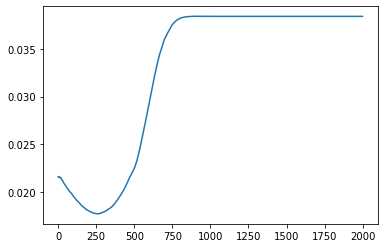

In [4]:
plt.plot(np.arange(n_epoch), metrics['aupr'])

<AxesSubplot:>

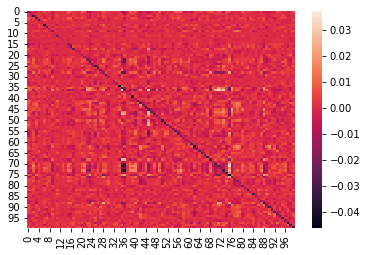

In [5]:
sns.heatmap(vim)

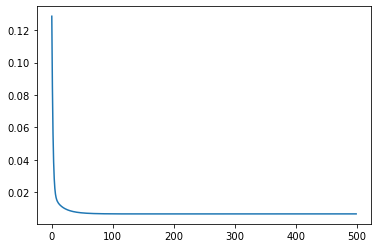

In [56]:
plt.plot(np.arange(500), metrics['loss'])